In [1]:
import numpy as np
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
#from tqdm.notebook import tqdm
from math import log
from tqdm import tqdm
from scipy.linalg import logm
import seaborn as sns
import random
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [16]:
hex_code = '#FCF3C5'

# Functions

In [3]:
def di(infected,
       beta,
       k
      ):
    return beta * k * (1-infected) * infected

In [4]:
def dim(infected,
        beta,
        k,
        P
       ):
    return beta * k * (1-sum(infected)) * P@infected

In [5]:
def dphi(lastphi,
         infected,
         beta,
         k,
         P):
    
    sumI = sum(infected)
    
    return beta * k * (1-sumI) * (np.linalg.matrix_power(P,2) - P) @ lastphi

In [6]:
class NSI:
    
    def __init__(self,
                 N,
                 T,
                 P,
                 beta, 
                 k,
                 seedI = None,
                 seedphi = None
                ):
        
        if seedI is None:
            I = [np.array([1/N,0,0,0])]
        else:
            I = seedI
            
        if seedphi is None:
            phi = [np.array([1,0,0,0])]
        else:
            phi = seedphi

        entropy = list()

        for t in range(1,T):

            infected = I[t-1]

            sumI = sum(infected)

            I.append(I[t-1] + dim(infected=infected, beta=beta, k=k, P=P))
            phi.append(phi[t-1] + dphi(lastphi=phi[t-1], infected=I[t-1], beta=beta, k=k, P=P))

        for t in range(T):
            d = I[t]
            d = d/sum(d)
            p = d[d > 0]
            h = -1*np.sum(p*np.log2(p))
            entropy.append(h)
            
        self.P = P
        self.beta = beta
        self.k = k
        self.N = N
        self.T = T
        
        #self.Hx = -1 * np.sum([i*np.log2(i) for i in phi[0]])
        self.I = I
        self.phi = phi
        self.H = entropy
        

In [7]:
def error_message(m, e):
    
    # m is the message, e is the probability of error
    
    r = random.random()
    
    if not r > e:
        m_out = random.choice(P[m,:].nonzero()[0])
    else:
        m_out = m
    
    return m_out

In [8]:
def change_m(m1, m2, gamma):
    
    r = random.random()
    
    if not r > gamma:
        m_poss = P[m1,:].nonzero()[0]
        
        if m2 in m_poss:
            m_out = m1
            
        else:
            m_out = m1
        
    else:
        m_out = m2
    
    return m_out

In [9]:
def si_homo_sim(N, e, beta, k, T=50, num_seeds=1, all0=True, pbar_on=True):
    
    pop_dict = {n: -1 for n in range(N)}
        
    for _ in range(num_seeds):
    
        node = random.randint(0, N - 1)

        if all0:
            pop_dict[node]= 0
        else:
            m = random.randint(0, P.shape[0]-1)
            G.nodes[node] = m
            print(f'Initial Seed: {m}')
            
    counts = {x: list() for x in range(-1, P.shape[0])}
    
    if pbar_on:
        pbar = tqdm(range(T))
    else:
        pbar = range(T)
    

    for t in pbar:

        valid_nodes = [node for node in pop_dict.keys() if pop_dict[node] != -1] # time step updates

        while len(valid_nodes) > 0:

            n = random.choice(valid_nodes)
            valid_nodes.remove(n)

            n_state = pop_dict[n]


            neighbors = np.random.randint(N, size=k)

            for ni in neighbors:

                if random.random() < beta:

                    ni_state = pop_dict[ni]

                    if ni_state < 0:
                        pop_dict[ni] = error_message(n_state, e)

                    else:
                        pass

                else:
                    pass


        cts = Counter(pop_dict.values())

        for x in counts.keys(): 
            counts[x].append(cts[x])
                
    return counts

# Parameters

In [29]:
beta = 0.1
avg_k = 4
err = 0.1
N = 10000
#T = int(log(N, R))\
T = 100

# Channel 

In [30]:
A = np.array([[0, 1, 1, 0],
             [1, 0, 0, 1],
             [1, 0, 0, 1],
             [0, 1, 1, 0]])
P = (1-err)*np.eye(4) + err/2*A

# Comparing Stochastic and Analytic

In [31]:
model1 = NSI(N=N, T=T, P=P, beta=beta, k=avg_k)

In [ ]:
sims = list()
for _ in range(20):
    sims.append(si_homo_sim(N=N, e=err, beta=beta, k=avg_k, T=T))
    
sims_np = np.array(sims)
np.save('simulated_binsym_2b_runs.npy', sims_np)

 97%|████████████████████████████████████████▋ | 97/100 [01:03<00:02,  1.19it/s]

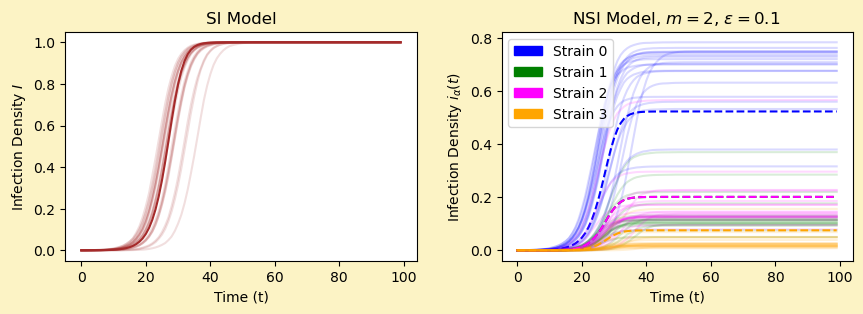

In [52]:
colors = ['blue', 'green', 'magenta', 'orange']

fig, axs = plt.subplots(1,2, figsize=(9,3.5), facecolor=hex_code)



for c in sims[0].keys():
    if not c < 0:
        axs[1].plot(range(100), [model1.I[i][c] for i in range(100)], label=c, alpha=1, linestyle='dashed',
                    color=colors[c])
        for t,s in enumerate(sims):
            axs[1].plot(range(100), [x/10000 for x in s[c]], label=c, alpha=0.15, color=colors[c])
            
            
for s in sims:
    axs[0].plot(range(100), [np.sum([(s[c][t]) for c in s.keys() if c >= 0])/N for t in range(100)], alpha=0.15, 
                color='brown')
axs[0].plot(range(100), [np.sum(i) for i in model1.I], color='brown')


patches = list()

for c in sims[0].keys():
    if not c < 0:
        patch = mpatches.Patch(color=colors[int(c)], label=f"Strain {int(c)}")
        patches.append(patch)
        
        
axs[0].set_title(r'SI Model')
axs[0].set_ylabel(r'Infection Density $I$')
axs[0].set_xlabel('Time (t)')        
    
axs[1].legend(handles=patches)

            
axs[1].set_title(r'NSI Model, $m=2$, $\epsilon = 0.1$ ')
axs[1].set_ylabel(r'Infection Density $i_\alpha(t)$')
axs[1].set_xlabel('Time (t)')
#plt.savefig('stoch_homo_approx.pdf')
fig.tight_layout(pad=2.0)
fig.savefig('/home/sagar/modeling-info-spread/reports/figures/stoch_homo_approx_bgcolor.pdf')

## $Y$ vs $\psi$

In [54]:
sim_phis = list()
sim_entropies = list()

for n,s in enumerate(sims):
    phi_t = defaultdict(list) # initialize list of phi for each time step
    H_t = list() # initialize list of entropies for each time step
    
    for t in range(T):
        phi = list() # initialize phi for each time step for entropy calculation
        sumI = N - s.get(-1)[t] # Final outbreak size
        
        for c in s.keys():
            if not c < 0:
                
                c_val = s[c][t]/sumI
                
                phi_t[c].append(c_val)
                phi.append(c_val) 
                
                
                
        phi = np.array(phi)
        
        phi = phi[phi > 0] # drop zeros to evoid errors in log
        H_t.append(-1*np.sum(phi * np.log2(phi)))
        
    sim_phis.append(phi_t)
    sim_entropies.append(H_t)

            

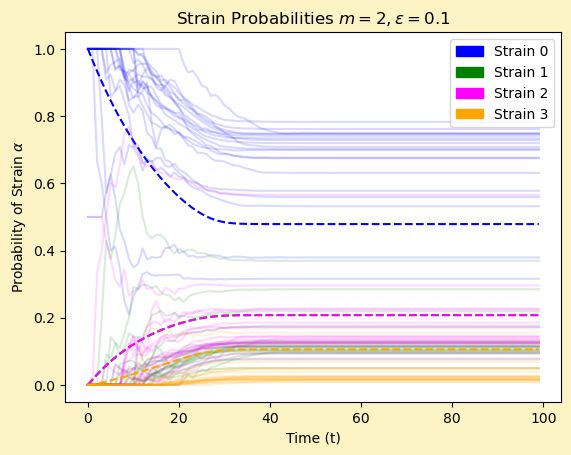

In [65]:
colors = ['blue', 'green', 'magenta', 'orange']

plt.figure(facecolor=hex_code)

for c in s.keys():
    if not c < 0:
        plt.plot(range(100), [model1.phi[i][c] for i in range(100)], label=c, alpha=1, linestyle='dashed',
                    color=colors[c])
        for t,s in enumerate(sim_phis):
            plt.plot(range(100), [x for x in s[c]], label=c, alpha=0.15, color=colors[c])
            
patches = list()

for c in sims[0].keys():
    if not c < 0:
        patch = mpatches.Patch(color=colors[int(c)], label=f"Strain {int(c)}")
        patches.append(patch)
            
plt.legend(handles=patches)
plt.xlabel(r'Time (t)')
plt.ylabel(r'Probability of Strain $\alpha$')
plt.title(r'Strain Probabilities $m=2, \epsilon=0.1$')

plt.savefig('/home/sagar/modeling-info-spread/reports/figures/stoch_homo_probs_bgcolor.pdf')

# Binary Symmetric Channel

In [12]:
B = np.array([[0,1],
             [1,0]])

C =(1-err)*np.eye(B.shape[0]) + err*B

In [13]:
model2 =  NSI(N=N, T=T, P=C, beta=beta, k=avg_k, seedI=[np.array([1/N, 0])], seedphi=[np.array([1,0])])

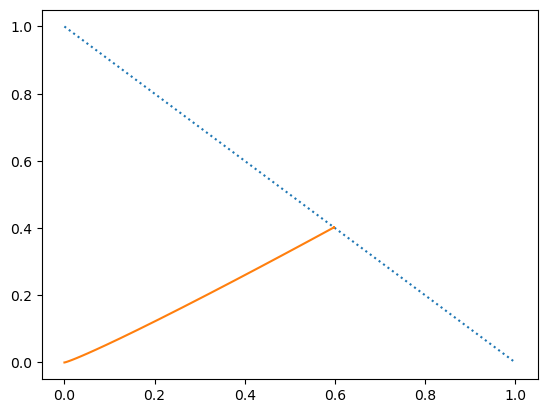

In [14]:
plt.plot(np.linspace(0, 1, 100), 1-np.linspace(0, 1, 100), linestyle='dotted')
plt.plot([i[0] for i in model2.I], [i[1] for i in model2.I])

/tmp/ipykernel_425671/1882473852.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple,label=r'$\epsilon$')


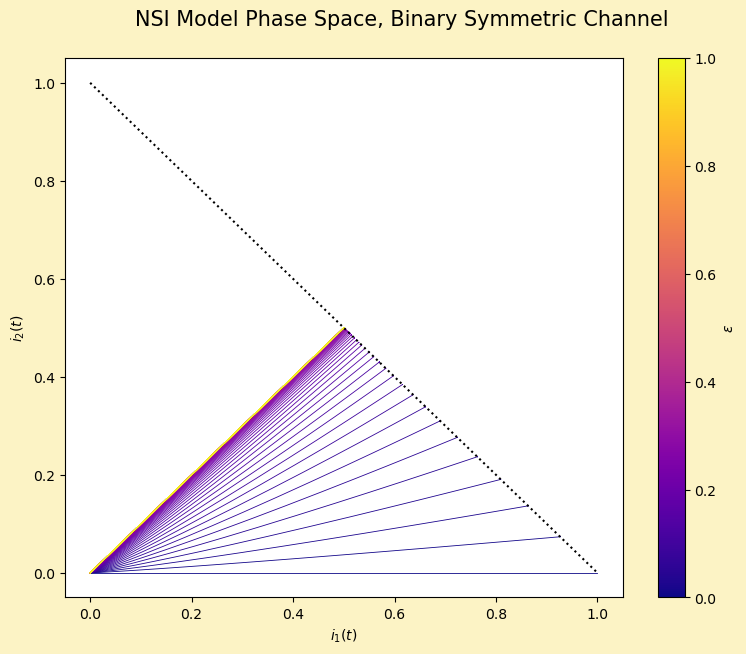

In [20]:
fig, ax = plt.subplots(figsize=(9,7), facecolor=hex_code)

binsymmodels = list() # accumulate each model
colormap = plt.cm.plasma # set colormap

for e in range(100):
    err = e/100
    C = (1-err)*np.eye(B.shape[0]) + err*B
    m = NSI(N=N, T=T, P=C, beta=beta, k=avg_k, seedI=[np.array([1/N, 0])], seedphi=[np.array([1,0])])
    binsymmodels.append(m)
    
    
for e, mod in enumerate(binsymmodels):
    color = colormap(e/100)
    plt.plot([i[0] for i in mod.I], [i[1] for i in mod.I], color=color, linewidth=0.6)
    
ax.plot(np.linspace(0, 1, 100), 1-np.linspace(0, 1, 100), linestyle='dotted', color='black')

ax.set_xlabel(r'$i_1(t)$')
ax.set_ylabel(r'$i_2(t)$')

fig.suptitle('NSI Model Phase Space, Binary Symmetric Channel', fontsize=15, y=0.95)

# setup the colorbar
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array([i/100 for i in range(100)])
plt.colorbar(scalarmappaple,label=r'$\epsilon$')

#plt.savefig('bin_sym_phase_space.pdf')

plt.savefig('bin_sym_phase_space_bgcolor.pdf')

# di_inf / de looks exponential-ish

In [16]:
for i in 
plt.plot([i[0] for i in mod.I], [i[1] for i in mod.I], color=cm(e/100))
    
#plt.plot(np.linspace(0, 1, 100), 1-np.linspace(0, 1, 100), linestyle='dotted')

SyntaxError: invalid syntax (<ipython-input-16-063165ac8f66>, line 1)

# beta and error heat map

In [120]:
runs = defaultdict(list)

for e_int in tqdm(range(1,100)):
    for b_int in range(1,100):
        
        e = e_int/100
        b = b_int*0.5/100
        
        run = NSI(N=N, T=T, P=(1-e)*np.eye(4) + e/2*A, beta=b, k=avg_k)
        
        runs[e].append(run)



  0%|          | 0/99 [00:00<?, ?it/s]

  1%|          | 1/99 [00:00<00:44,  2.21it/s]

  2%|▏         | 2/99 [00:00<00:43,  2.25it/s]

  3%|▎         | 3/99 [00:01<00:43,  2.19it/s]

  4%|▍         | 4/99 [00:01<00:42,  2.22it/s]

  5%|▌         | 5/99 [00:02<00:41,  2.27it/s]

  6%|▌         | 6/99 [00:02<00:40,  2.28it/s]

  7%|▋         | 7/99 [00:03<00:40,  2.27it/s]

  8%|▊         | 8/99 [00:03<00:39,  2.29it/s]

  9%|▉         | 9/99 [00:04<00:41,  2.15it/s]

 10%|█         | 10/99 [00:04<00:42,  2.11it/s]

 11%|█         | 11/99 [00:05<00:41,  2.10it/s]

 12%|█▏        | 12/99 [00:05<00:40,  2.14it/s]

 13%|█▎        | 13/99 [00:05<00:40,  2.15it/s]

 14%|█▍        | 14/99 [00:06<00:39,  2.17it/s]

 15%|█▌        | 15/99 [00:06<00:38,  2.16it/s]

 16%|█▌        | 16/99 [00:07<00:37,  2.19it/s]

 17%|█▋        | 17/99 [00:07<00:36,  2.24it/s]

 18%|█▊        | 18/99 [00:08<00:35,  2.27it/s]

 19%|█▉        | 19/99 [00:08<00:35,  2.26it/s]

 20%|██        | 20/99 [00:09<00:35,

In [121]:
#H_map = np.zeros(99,99)
e_vals = sorted(runs.keys())

H_map = np.array([[m.H[-1] for m in runs.get(e)] for e in e_vals])

In [122]:
H_map.shape

(99, 99)

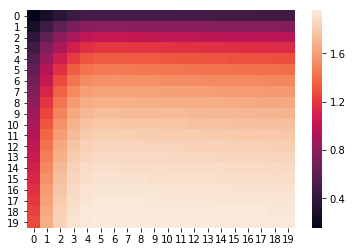

In [123]:
sns.heatmap(H_map[:20, :20])

In [153]:
sim_runs = defaultdict(dict)

for e_int in tqdm(range(1,10)):
    for b_int in range(1,10):
        
        e = e_int/10
        b = b_int/100
        
        run = si_homo_sim(N=N, e=e, beta=b, k=avg_k, T=T)
        
        sim_runs[e][b] = run
        
        





  0%|          | 0/9 [00:00<?, ?it/s]




  0%|          | 0/100 [00:00<?, ?it/s]




100%|██████████| 100/100 [00:00<00:00, 644.18it/s][A





  0%|          | 0/100 [00:00<?, ?it/s]




 71%|███████   | 71/100 [00:00<00:00, 701.19it/s]




100%|██████████| 100/100 [00:00<00:00, 484.48it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




 41%|████      | 41/100 [00:00<00:00, 403.35it/s]




 54%|█████▍    | 54/100 [00:00<00:00, 187.16it/s]




 65%|██████▌   | 65/100 [00:00<00:00, 61.42it/s] 




 74%|███████▍  | 74/100 [00:01<00:01, 18.80it/s]




 81%|████████  | 81/100 [00:03<00:02,  9.12it/s]




 86%|████████▌ | 86/100 [00:05<00:02,  5.27it/s]




 90%|█████████ | 90/100 [00:07<00:02,  3.77it/s]




 93%|█████████▎| 93/100 [00:08<00:02,  2.96it/s]




 95%|█████████▌| 95/100 [00:09<00:02,  2.48it/s]




 97%|█████████▋| 97/100 [00:11<00:01,  2.13it/s]




 98%|█████████▊| 98/100 [00:11<00:01,  1.94it/s]




 99%|█████████▉| 99/100 [00:12<00:00,  1.80it/s]




100%|██████████

 57%|█████▋    | 57/100 [00:12<00:22,  1.90it/s]




 58%|█████▊    | 58/100 [00:12<00:23,  1.82it/s]




 59%|█████▉    | 59/100 [00:13<00:23,  1.76it/s]




 60%|██████    | 60/100 [00:13<00:23,  1.72it/s]




 61%|██████    | 61/100 [00:14<00:22,  1.70it/s]




 62%|██████▏   | 62/100 [00:15<00:22,  1.68it/s]




 63%|██████▎   | 63/100 [00:15<00:22,  1.67it/s]




 64%|██████▍   | 64/100 [00:16<00:21,  1.66it/s]




 65%|██████▌   | 65/100 [00:16<00:21,  1.66it/s]




 66%|██████▌   | 66/100 [00:17<00:20,  1.63it/s]




 67%|██████▋   | 67/100 [00:18<00:20,  1.64it/s]




 68%|██████▊   | 68/100 [00:18<00:19,  1.64it/s]




 69%|██████▉   | 69/100 [00:19<00:18,  1.64it/s]




 70%|███████   | 70/100 [00:19<00:18,  1.64it/s]




 71%|███████   | 71/100 [00:20<00:17,  1.64it/s]




 72%|███████▏  | 72/100 [00:21<00:17,  1.63it/s]




 73%|███████▎  | 73/100 [00:21<00:17,  1.57it/s]




 74%|███████▍  | 74/100 [00:22<00:16,  1.56it/s]




 75%|███████▌  | 75/100 [00:23<00:15,  1.57it/

 86%|████████▌ | 86/100 [00:30<00:09,  1.54it/s]




 87%|████████▋ | 87/100 [00:31<00:08,  1.53it/s]




 88%|████████▊ | 88/100 [00:31<00:07,  1.55it/s]




 89%|████████▉ | 89/100 [00:32<00:07,  1.57it/s]




 90%|█████████ | 90/100 [00:33<00:06,  1.57it/s]




 91%|█████████ | 91/100 [00:33<00:05,  1.55it/s]




 92%|█████████▏| 92/100 [00:34<00:05,  1.57it/s]




 93%|█████████▎| 93/100 [00:34<00:04,  1.59it/s]




 94%|█████████▍| 94/100 [00:35<00:03,  1.57it/s]




 95%|█████████▌| 95/100 [00:36<00:03,  1.58it/s]




 96%|█████████▌| 96/100 [00:36<00:02,  1.59it/s]




 97%|█████████▋| 97/100 [00:37<00:01,  1.60it/s]




 98%|█████████▊| 98/100 [00:38<00:01,  1.57it/s]




 99%|█████████▉| 99/100 [00:38<00:00,  1.57it/s]




100%|██████████| 100/100 [00:39<00:00,  2.54it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




 22%|██▏       | 22/100 [00:00<00:00, 199.93it/s]




 28%|██▊       | 28/100 [00:00<00:01, 36.64it/s] 




 33%|███▎      | 33/100 [00:01<00:06,  9.73it/s]




100%|██████████| 100/100 [00:38<00:00,  2.60it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




 30%|███       | 30/100 [00:00<00:00, 250.04it/s]




 38%|███▊      | 38/100 [00:00<00:01, 37.87it/s] 




 44%|████▍     | 44/100 [00:02<00:06,  8.46it/s]




 49%|████▉     | 49/100 [00:05<00:12,  4.02it/s]




 52%|█████▏    | 52/100 [00:07<00:17,  2.74it/s]




 55%|█████▌    | 55/100 [00:09<00:19,  2.25it/s]




 57%|█████▋    | 57/100 [00:10<00:21,  1.97it/s]




 59%|█████▉    | 59/100 [00:11<00:22,  1.81it/s]




 60%|██████    | 60/100 [00:12<00:22,  1.75it/s]




 61%|██████    | 61/100 [00:13<00:22,  1.72it/s]




 62%|██████▏   | 62/100 [00:13<00:22,  1.69it/s]




 63%|██████▎   | 63/100 [00:14<00:22,  1.67it/s]




 64%|██████▍   | 64/100 [00:15<00:21,  1.66it/s]




 65%|██████▌   | 65/100 [00:15<00:21,  1.65it/s]




 66%|██████▌   | 66/100 [00:16<00:20,  1.62it/s]




 67%|██████▋   | 67/100 [00:16<00:20,  1.62it/s]




 68%|██████▊   | 68/100 [00:17<00:19,  1.62it/s]




 57%|█████▋    | 57/100 [00:14<00:27,  1.54it/s]




 58%|█████▊    | 58/100 [00:15<00:27,  1.51it/s]




 59%|█████▉    | 59/100 [00:15<00:26,  1.52it/s]




 60%|██████    | 60/100 [00:16<00:26,  1.54it/s]




 61%|██████    | 61/100 [00:16<00:25,  1.55it/s]




 62%|██████▏   | 62/100 [00:17<00:24,  1.56it/s]




 63%|██████▎   | 63/100 [00:18<00:23,  1.56it/s]




 64%|██████▍   | 64/100 [00:18<00:22,  1.57it/s]




 65%|██████▌   | 65/100 [00:19<00:22,  1.55it/s]




 66%|██████▌   | 66/100 [00:20<00:21,  1.55it/s]




 67%|██████▋   | 67/100 [00:20<00:21,  1.54it/s]




 68%|██████▊   | 68/100 [00:21<00:20,  1.54it/s]




 69%|██████▉   | 69/100 [00:22<00:20,  1.54it/s]




 70%|███████   | 70/100 [00:22<00:19,  1.55it/s]




 71%|███████   | 71/100 [00:23<00:18,  1.56it/s]




 72%|███████▏  | 72/100 [00:24<00:18,  1.55it/s]




 73%|███████▎  | 73/100 [00:24<00:17,  1.56it/s]




 74%|███████▍  | 74/100 [00:25<00:16,  1.56it/s]




 75%|███████▌  | 75/100 [00:25<00:15,  1.57it/

 77%|███████▋  | 77/100 [00:17<00:14,  1.58it/s]




 78%|███████▊  | 78/100 [00:18<00:14,  1.57it/s]




 79%|███████▉  | 79/100 [00:19<00:13,  1.57it/s]




 80%|████████  | 80/100 [00:19<00:12,  1.56it/s]




 81%|████████  | 81/100 [00:20<00:12,  1.57it/s]




 82%|████████▏ | 82/100 [00:21<00:11,  1.57it/s]




 83%|████████▎ | 83/100 [00:21<00:10,  1.57it/s]




 84%|████████▍ | 84/100 [00:22<00:10,  1.56it/s]




 85%|████████▌ | 85/100 [00:22<00:09,  1.56it/s]




 86%|████████▌ | 86/100 [00:23<00:09,  1.54it/s]




 87%|████████▋ | 87/100 [00:24<00:08,  1.55it/s]




 88%|████████▊ | 88/100 [00:24<00:07,  1.56it/s]




 89%|████████▉ | 89/100 [00:25<00:07,  1.55it/s]




 90%|█████████ | 90/100 [00:26<00:06,  1.55it/s]




 91%|█████████ | 91/100 [00:26<00:05,  1.56it/s]




 92%|█████████▏| 92/100 [00:27<00:05,  1.56it/s]




 93%|█████████▎| 93/100 [00:28<00:04,  1.57it/s]




 94%|█████████▍| 94/100 [00:28<00:03,  1.58it/s]




 95%|█████████▌| 95/100 [00:29<00:03,  1.57it/

 69%|██████▉   | 69/100 [00:10<00:14,  2.12it/s]




 71%|███████   | 71/100 [00:11<00:14,  1.96it/s]




 72%|███████▏  | 72/100 [00:12<00:15,  1.80it/s]




 73%|███████▎  | 73/100 [00:12<00:15,  1.76it/s]




 74%|███████▍  | 74/100 [00:13<00:15,  1.73it/s]




 75%|███████▌  | 75/100 [00:14<00:14,  1.71it/s]




 76%|███████▌  | 76/100 [00:14<00:14,  1.69it/s]




 77%|███████▋  | 77/100 [00:15<00:14,  1.62it/s]




 78%|███████▊  | 78/100 [00:16<00:14,  1.53it/s]




 79%|███████▉  | 79/100 [00:16<00:13,  1.55it/s]




 80%|████████  | 80/100 [00:17<00:12,  1.54it/s]




 81%|████████  | 81/100 [00:18<00:12,  1.55it/s]




 82%|████████▏ | 82/100 [00:18<00:11,  1.56it/s]




 83%|████████▎ | 83/100 [00:19<00:10,  1.56it/s]




 84%|████████▍ | 84/100 [00:20<00:10,  1.57it/s]




 85%|████████▌ | 85/100 [00:20<00:09,  1.57it/s]




 86%|████████▌ | 86/100 [00:21<00:08,  1.56it/s]




 87%|████████▋ | 87/100 [00:21<00:08,  1.57it/s]




 88%|████████▊ | 88/100 [00:22<00:07,  1.56it/

 90%|█████████ | 90/100 [00:37<00:06,  1.56it/s]




 91%|█████████ | 91/100 [00:37<00:05,  1.57it/s]




 92%|█████████▏| 92/100 [00:38<00:05,  1.56it/s]




 93%|█████████▎| 93/100 [00:39<00:04,  1.56it/s]




 94%|█████████▍| 94/100 [00:39<00:03,  1.57it/s]




 95%|█████████▌| 95/100 [00:40<00:03,  1.57it/s]




 96%|█████████▌| 96/100 [00:40<00:02,  1.57it/s]




 97%|█████████▋| 97/100 [00:41<00:01,  1.56it/s]




 98%|█████████▊| 98/100 [00:42<00:01,  1.57it/s]




 99%|█████████▉| 99/100 [00:42<00:00,  1.55it/s]




100%|██████████| 100/100 [00:43<00:00,  2.29it/s]




 67%|██████▋   | 6/9 [21:13<10:37, 212.63s/it]




  0%|          | 0/100 [00:00<?, ?it/s]




100%|██████████| 100/100 [00:00<00:00, 669.67it/s][A





  0%|          | 0/100 [00:00<?, ?it/s]




 56%|█████▌    | 56/100 [00:00<00:00, 557.06it/s]




 73%|███████▎  | 73/100 [00:00<00:00, 284.10it/s]




100%|██████████| 100/100 [00:01<00:00, 73.19it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




 43%|████▎  

 68%|██████▊   | 68/100 [00:24<00:20,  1.55it/s]




 69%|██████▉   | 69/100 [00:24<00:19,  1.56it/s]




 70%|███████   | 70/100 [00:25<00:19,  1.56it/s]




 71%|███████   | 71/100 [00:26<00:18,  1.56it/s]




 72%|███████▏  | 72/100 [00:26<00:18,  1.53it/s]




 73%|███████▎  | 73/100 [00:27<00:17,  1.54it/s]




 74%|███████▍  | 74/100 [00:28<00:16,  1.55it/s]




 75%|███████▌  | 75/100 [00:28<00:16,  1.56it/s]




 76%|███████▌  | 76/100 [00:29<00:15,  1.55it/s]




 77%|███████▋  | 77/100 [00:30<00:14,  1.56it/s]




 78%|███████▊  | 78/100 [00:30<00:14,  1.56it/s]




 79%|███████▉  | 79/100 [00:31<00:13,  1.56it/s]




 80%|████████  | 80/100 [00:32<00:12,  1.56it/s]




 81%|████████  | 81/100 [00:32<00:12,  1.56it/s]




 82%|████████▏ | 82/100 [00:33<00:11,  1.53it/s]




 83%|████████▎ | 83/100 [00:34<00:11,  1.54it/s]




 84%|████████▍ | 84/100 [00:34<00:10,  1.55it/s]




 85%|████████▌ | 85/100 [00:35<00:09,  1.56it/s]




 86%|████████▌ | 86/100 [00:35<00:08,  1.56it/

 49%|████▉     | 49/100 [00:12<00:32,  1.58it/s]




 50%|█████     | 50/100 [00:13<00:31,  1.57it/s]




 51%|█████     | 51/100 [00:14<00:31,  1.57it/s]




 52%|█████▏    | 52/100 [00:14<00:30,  1.56it/s]




 53%|█████▎    | 53/100 [00:15<00:29,  1.58it/s]




 54%|█████▍    | 54/100 [00:15<00:28,  1.59it/s]




 55%|█████▌    | 55/100 [00:16<00:28,  1.59it/s]




 56%|█████▌    | 56/100 [00:17<00:27,  1.58it/s]




 57%|█████▋    | 57/100 [00:17<00:27,  1.57it/s]




 58%|█████▊    | 58/100 [00:18<00:26,  1.57it/s]




 59%|█████▉    | 59/100 [00:19<00:26,  1.56it/s]




 60%|██████    | 60/100 [00:19<00:25,  1.57it/s]




 61%|██████    | 61/100 [00:20<00:24,  1.57it/s]




 62%|██████▏   | 62/100 [00:21<00:24,  1.55it/s]




 63%|██████▎   | 63/100 [00:21<00:23,  1.57it/s]




 64%|██████▍   | 64/100 [00:22<00:22,  1.58it/s]




 65%|██████▌   | 65/100 [00:22<00:22,  1.58it/s]




 66%|██████▌   | 66/100 [00:23<00:21,  1.58it/s]




 67%|██████▋   | 67/100 [00:24<00:20,  1.57it/

 86%|████████▌ | 86/100 [00:31<00:09,  1.53it/s]




 87%|████████▋ | 87/100 [00:32<00:08,  1.54it/s]




 88%|████████▊ | 88/100 [00:32<00:07,  1.55it/s]




 89%|████████▉ | 89/100 [00:33<00:07,  1.55it/s]




 90%|█████████ | 90/100 [00:34<00:06,  1.55it/s]




 91%|█████████ | 91/100 [00:34<00:05,  1.54it/s]




 92%|█████████▏| 92/100 [00:35<00:05,  1.54it/s]




 93%|█████████▎| 93/100 [00:35<00:04,  1.55it/s]




 94%|█████████▍| 94/100 [00:36<00:03,  1.55it/s]




 95%|█████████▌| 95/100 [00:37<00:03,  1.56it/s]




 96%|█████████▌| 96/100 [00:37<00:02,  1.56it/s]




 97%|█████████▋| 97/100 [00:38<00:01,  1.56it/s]




 98%|█████████▊| 98/100 [00:39<00:01,  1.57it/s]




 99%|█████████▉| 99/100 [00:39<00:00,  1.57it/s]




100%|██████████| 100/100 [00:40<00:00,  2.47it/s]





  0%|          | 0/100 [00:00<?, ?it/s]




 22%|██▏       | 22/100 [00:00<00:00, 214.48it/s]




 29%|██▉       | 29/100 [00:00<00:01, 41.73it/s] 




 34%|███▍      | 34/100 [00:02<00:06,  9.83it/s]




In [240]:
sim_e_vals = sorted(sim_runs.keys())


sim_H = np.zeros((len(sim_e_vals), len(sim_runs.get(sim_e_vals[0]).keys())))



for idxe, e in enumerate(sim_e_vals):
    
    e_keys = sorted(sim_runs.get(e).keys())
    
    for idxb, b in enumerate(e_keys):
        
        run = sim_runs.get(e).get(b)
        
        sumI = N - run.get(-1)[-1]
        phi = list()
        
        for c in [i for i in run.keys() if not i < 0]:
            
            phi.append(run[c][-1]/sumI)
            
        phi = np.array(phi)
        
        phi = phi[phi > 0]
        
        sim_H[idxe, idxb] = -np.sum(phi * np.log2(phi))       
                

                        
                    
                    

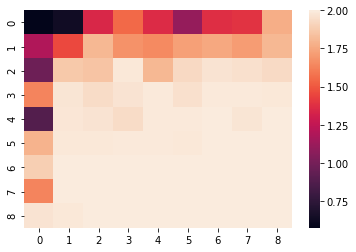

In [241]:
sns.heatmap(sim_H)

# Mutual Information

In [216]:
model1.phi[-1]

array([0.47868606, 0.20772986, 0.20772986, 0.10585423])

In [217]:
I_test = -np.sum(model1.phi[-1] * np.log2(model1.phi[-1])) - -np.sum(model1.phi[-1] * np.log2(model1.phi[-1]))

In [218]:
for i in 

0.0

In [3]:
import numpy as np
np.zeros(5)

array([0., 0., 0., 0., 0.])